# Exploration notebook

In this notebook you can find the the explorations done regarding the project. It contains the following sections:
- 1. Imports
- 2. Ingestion
- 3. Preprocessing
- 4. Feature selection
- 5. Feature engineering
- 6. Training the model(s)


<a id='f'></a>
# 1. Imports

In this section we import the necessary packages

In [31]:
import pandas as pd
import numpy as np
import xlrd
from pathlib import Path
import os

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, mean_absolute_percentage_error

from sklego.preprocessing import RepeatingBasisFunction

import matplotlib.pyplot as plt

import seaborn as sns

%matplotlib inline 

<a id='f'></a>
# 2. Ingestion

In this section, we read in the greenhouse data from the Automatoes team and the weather data.

In [2]:
team = "Automatoes"

In [3]:
path_greenhouse_csv = os.path.abspath(f'../data/{team}/GreenhouseClimate.csv')

path_weather_csv = os.path.abspath(f'../data/Weather.csv')

In [4]:
df_greenhouse = pd.read_csv(path_greenhouse_csv)
df_weather = pd.read_csv(path_weather_csv)

<a id='f'></a>
# 3. Preprocessing

In this section we preprocess the data

In [5]:
df_greenhouse = (df_greenhouse
        .assign(time = lambda df: df["time"].apply(lambda col: pd.Timestamp(xlrd.xldate_as_datetime(col, 0))))
        .set_index('time'))

df_weather = (df_weather
        .assign(time = lambda df: df["time"].apply(lambda col: pd.Timestamp(xlrd.xldate_as_datetime(col, 0))))
        .set_index('time'))

data = df_weather.join(df_greenhouse)

<a id='f'></a>
# 4. Feature selection

In this section, we select the features that we want to keep

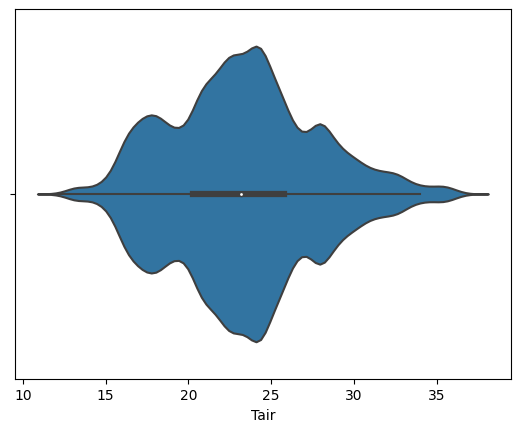

In [6]:
# A check wether we have sufficient variation in Tair across the dataset
sns.violinplot(x="Tair", data = data);

In [7]:
# Check which columns have a lot of missing values
number_of_entries = len(data.index)
missing_values = (data
                  .isna()
                  .sum()
                  .to_frame(name="number_missing_values")
                  .assign(percentage_missing = lambda df: df["number_missing_values"]/number_of_entries*100)
                  .loc[lambda df: df["percentage_missing"] > 5.0]
                 )
missing_values

,number_missing_values,percentage_missing
int_blue_vip,22152,46.334372
int_farred_vip,22152,46.334372
int_red_vip,22152,46.334372
int_white_vip,22152,46.334372
t_vent_sp,12576,26.304671


In [8]:
# Drop columns which have too many missing values
data = data.drop(columns=['int_blue_vip','int_farred_vip','int_red_vip','int_white_vip','t_vent_sp'])

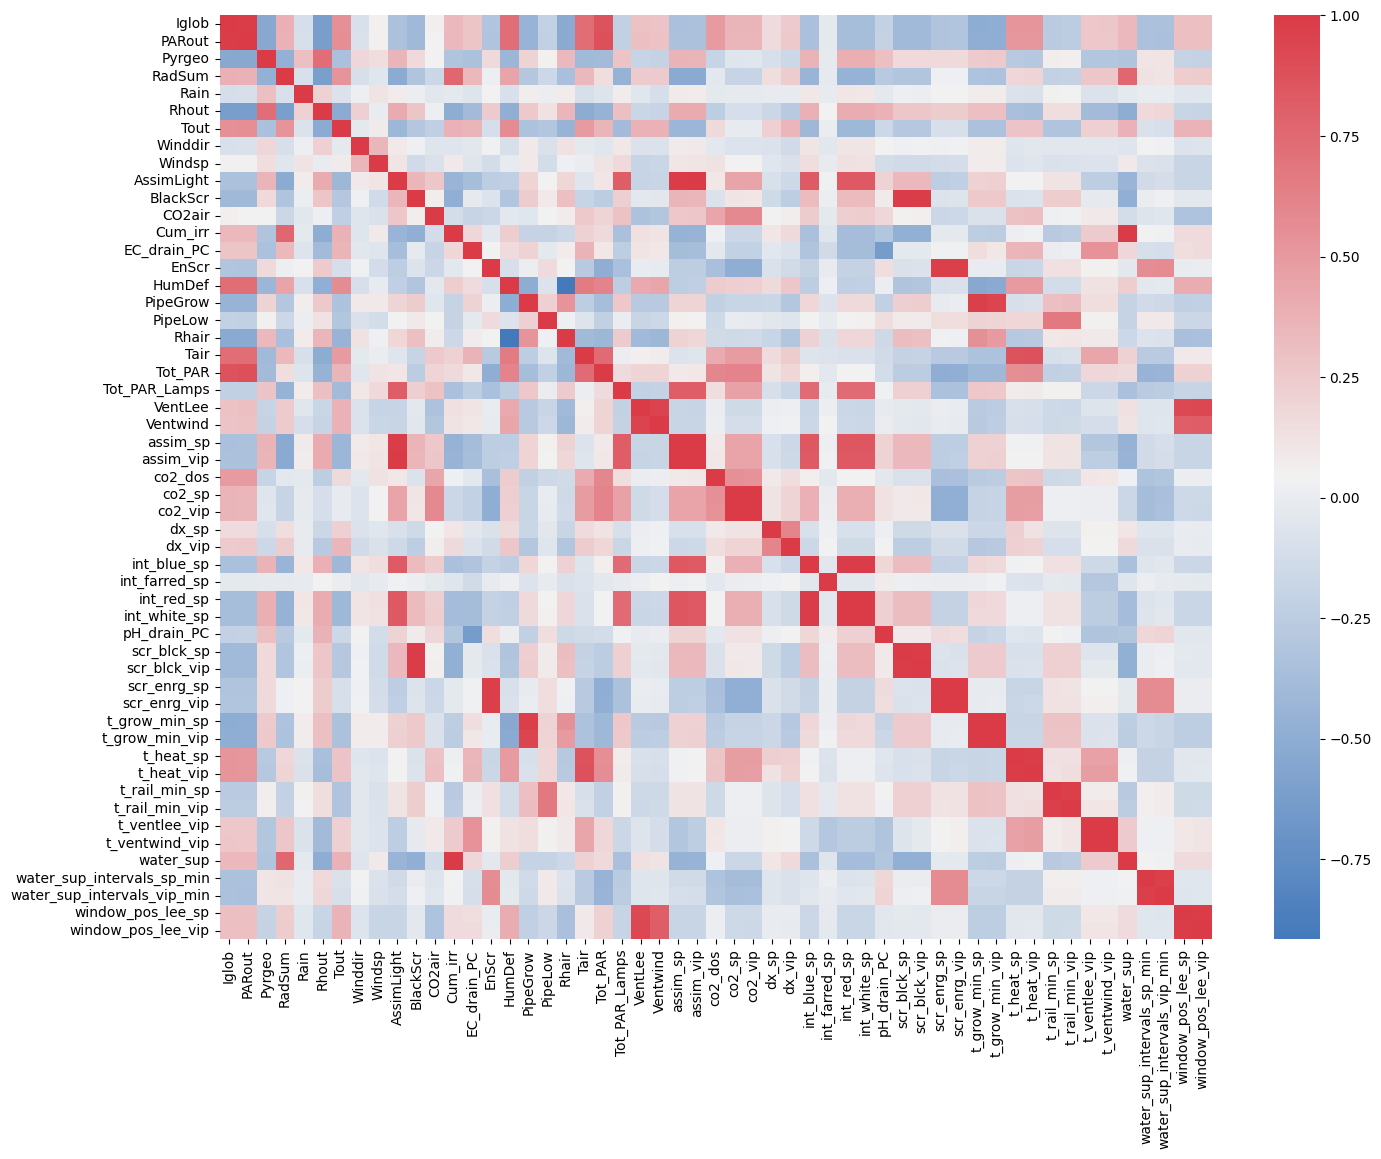

In [9]:
# Check the correlation between the different features
fig, ax = plt.subplots(figsize = (16,12))
sns.heatmap(data.iloc[:, 1:].corr(), cmap = sns.diverging_palette(250, 10, as_cmap=True), ax = ax);

In [10]:
# Filter on the features that have a significant correlation
df_correlated_features = (data
                       .iloc[:, 1:]
                       .corr()
                       .loc["Tair"]
                       .to_frame(name="correlation_Tair")
                       .loc[lambda df: abs(df["correlation_Tair"])>0.50]
                      )
correlated_features = list(df_correlated_features.index.values)
data = data[correlated_features]

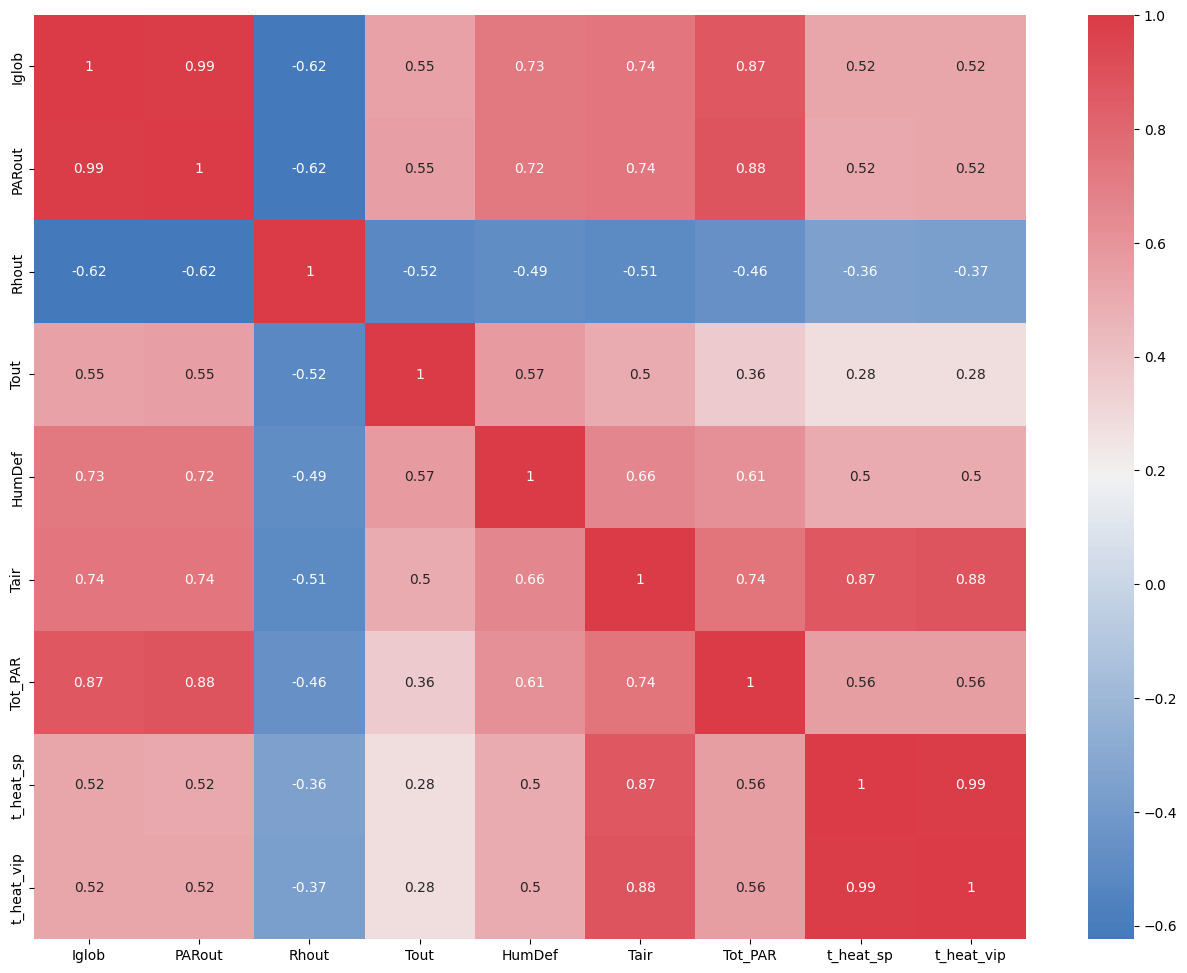

In [11]:
# Check the correlation between the different significant features
fig, ax = plt.subplots(figsize = (16,12))
sns.heatmap(data.iloc[:, :].corr(),annot=True, cmap = sns.diverging_palette(250, 10, as_cmap=True), ax = ax);

In [12]:
# Drop columns which are too correlated with each other
data = data.drop(columns=['PARout','Tot_PAR','t_heat_vip'])

In [13]:
# Fill the remaining NaN values with the average and resample to 1 hours
data = data.fillna(data.mean()).resample('1H').mean()

In [14]:
data

,Iglob,Rhout,Tout,HumDef,Tair,t_heat_sp
time,,,,,,
2019-12-16 00:00:00,0.000000,81.250000,6.791667,7.051667,21.450000,21.392907
2019-12-16 01:00:00,0.000000,84.123077,6.292308,7.271538,21.038462,21.392907
2019-12-16 02:00:00,0.000000,85.636364,6.136364,7.063636,21.036364,21.392907
2019-12-16 03:00:00,0.000000,88.225000,6.083333,7.061667,21.025000,21.392907
2019-12-16 04:00:00,0.000000,90.276923,6.023077,6.912308,20.892308,21.392907
...,...,...,...,...,...,...
2020-05-29 20:00:00,115.363637,44.718182,19.245455,11.234545,22.381818,10.000000
2020-05-29 21:00:00,20.416667,62.333333,17.425000,7.255833,20.116667,10.000000
2020-05-29 22:00:00,0.000000,68.300000,16.038462,5.021538,18.676923,10.000000


<a id='f'></a>
# 5. Feature engineering

In this section, we generate extra features that are useful for the model

In [15]:
data = (data
       .assign(t=lambda df: np.arange(len(df.index)) - (len(df.index) -1),
            hour_of_day=lambda df: df.index.hour,
            month=lambda df: df.index.month))

In [16]:
data

,Iglob,Rhout,Tout,HumDef,Tair,t_heat_sp,t,hour_of_day,month
time,,,,,,,,,
2019-12-16 00:00:00,0.000000,81.250000,6.791667,7.051667,21.450000,21.392907,-3984,0,12
2019-12-16 01:00:00,0.000000,84.123077,6.292308,7.271538,21.038462,21.392907,-3983,1,12
2019-12-16 02:00:00,0.000000,85.636364,6.136364,7.063636,21.036364,21.392907,-3982,2,12
2019-12-16 03:00:00,0.000000,88.225000,6.083333,7.061667,21.025000,21.392907,-3981,3,12
2019-12-16 04:00:00,0.000000,90.276923,6.023077,6.912308,20.892308,21.392907,-3980,4,12
...,...,...,...,...,...,...,...,...,...
2020-05-29 20:00:00,115.363637,44.718182,19.245455,11.234545,22.381818,10.000000,-4,20,5
2020-05-29 21:00:00,20.416667,62.333333,17.425000,7.255833,20.116667,10.000000,-3,21,5
2020-05-29 22:00:00,0.000000,68.300000,16.038462,5.021538,18.676923,10.000000,-2,22,5


<a id='f'></a>
# 6. Training the model(s)

In this section we train several models to see which one is best. First we split the data correctly in train and test and visualise it.

In [17]:
# Prepare the training and testing data
all_data = data.copy()

train = all_data.loc[:'2020-05-29']
test = all_data.loc['2020-05-29':]

X_train = train.drop(columns="Tair")
y_train = train[['Tair']]
X_test = test.drop(columns="Tair")
y_test = test[['Tair']]

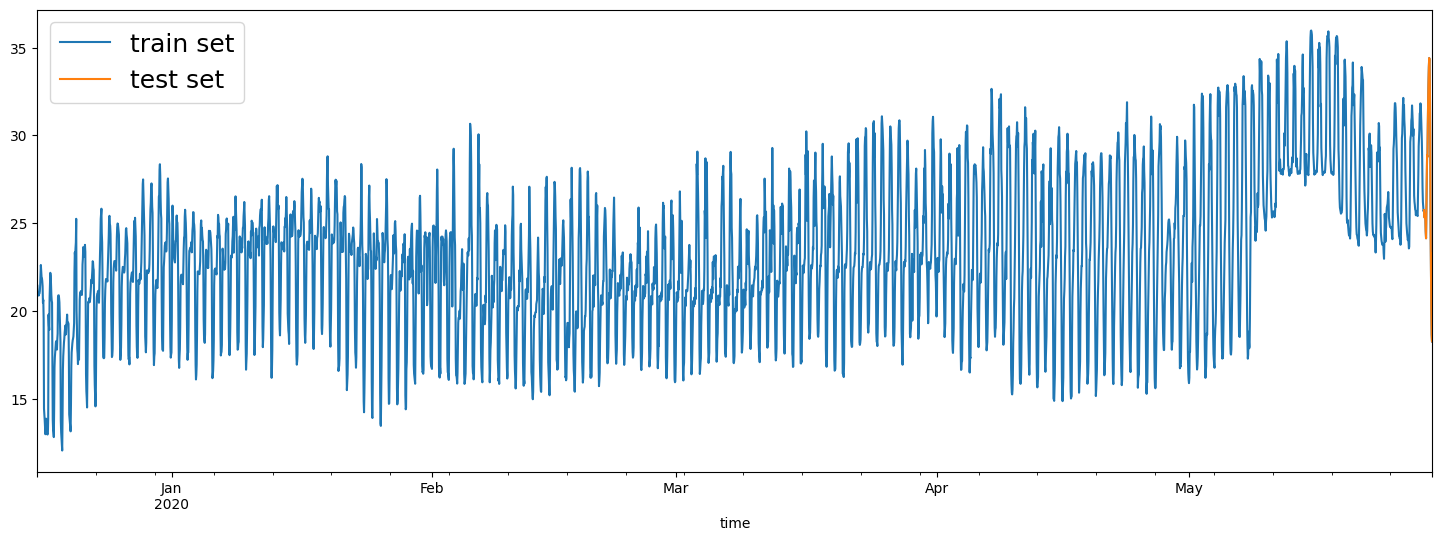

In [18]:
# Visualisation of the training and testing data.
fig, ax = plt.subplots(figsize=(18,6))
train['Tair'].plot(ax=ax)
test['Tair'].plot(ax=ax)
ax.legend(["train set", "test set"], prop={'size': 18});

<a id='f'></a>
## Training model (Linear Regression + GridSearchCV)

In this section we train a linear regression model with GridSearchCV. 

In [19]:
rbf = RepeatingBasisFunction(n_periods=24,
                             remainder='passthrough',
                             column='hour_of_day')
model = Pipeline([
    ('preprocess', rbf),
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

parameters = {
    'model__fit_intercept':[True, False]
}

tscv = TimeSeriesSplit(n_splits=6)

for train_index, test_index in tscv.split(X_train):
    print(f"TRAIN: [{train_index.min(), train_index.max()}]", 
         f"TEST: [{test_index.min(), test_index.max()}]")

TRAIN: [(0, 569)] TEST: [(570, 1138)]
TRAIN: [(0, 1138)] TEST: [(1139, 1707)]
TRAIN: [(0, 1707)] TEST: [(1708, 2276)]
TRAIN: [(0, 2276)] TEST: [(2277, 2845)]
TRAIN: [(0, 2845)] TEST: [(2846, 3414)]
TRAIN: [(0, 3414)] TEST: [(3415, 3983)]


In [20]:
gsearch = GridSearchCV(estimator=model, cv=tscv,
                        param_grid=parameters)

gsearch.fit(X_train, y_train)

all_data['grid_pred'] = gsearch.predict(all_data.drop(columns="Tair"))

In [32]:
train_pred = gsearch.predict(X_train)
test_pred = gsearch.predict(X_test)

In [34]:
# Calculate scores.
mae_train = mean_absolute_error(y_train, train_pred).round(3)
mse_train = mean_squared_error(y_train, train_pred).round(3)
rmse_train = np.sqrt(mean_squared_error(y_train, train_pred)).round(3)
mape_train = mean_absolute_percentage_error(y_train, train_pred).round(3)
r2_train = r2_score(y_train, train_pred).round(3)

mae_test = mean_absolute_error(y_test, test_pred).round(3)
mse_test = mean_squared_error(y_test, test_pred).round(3)
rmse_test = np.sqrt(mean_squared_error(y_test, test_pred)).round(3)
mape_test = mean_absolute_percentage_error(y_test, test_pred).round(3)
r2_test = r2_score(y_test, test_pred).round(3)



# Report. 
print(f'TRAIN | MAE: {mae_train}')
print(f'TRAIN | MSE: {mse_train}')
print(f'TRAIN | RMSE: {rmse_train}')
print(f'TRAIN | MAPE: {mape_train}')
print(f'TRAIN | r2: {r2_train}')
print(f'TEST | MAE: {mae_test}')
print(f'TEST | MSE: {mse_test}')
print(f'TEST | RMSE: {rmse_test}')
print(f'TEST | MAPE: {mape_test}')
print(f'TEST | r2: {r2_test}')

TRAIN | MAE: 0.98
TRAIN | MSE: 1.844
TRAIN | RMSE: 1.358
TRAIN | MAPE: 0.043
TRAIN | r2: 0.903
TEST | MAE: 2.454
TEST | MSE: 12.241
TEST | RMSE: 3.499
TEST | MAPE: 0.097
TEST | r2: 0.434


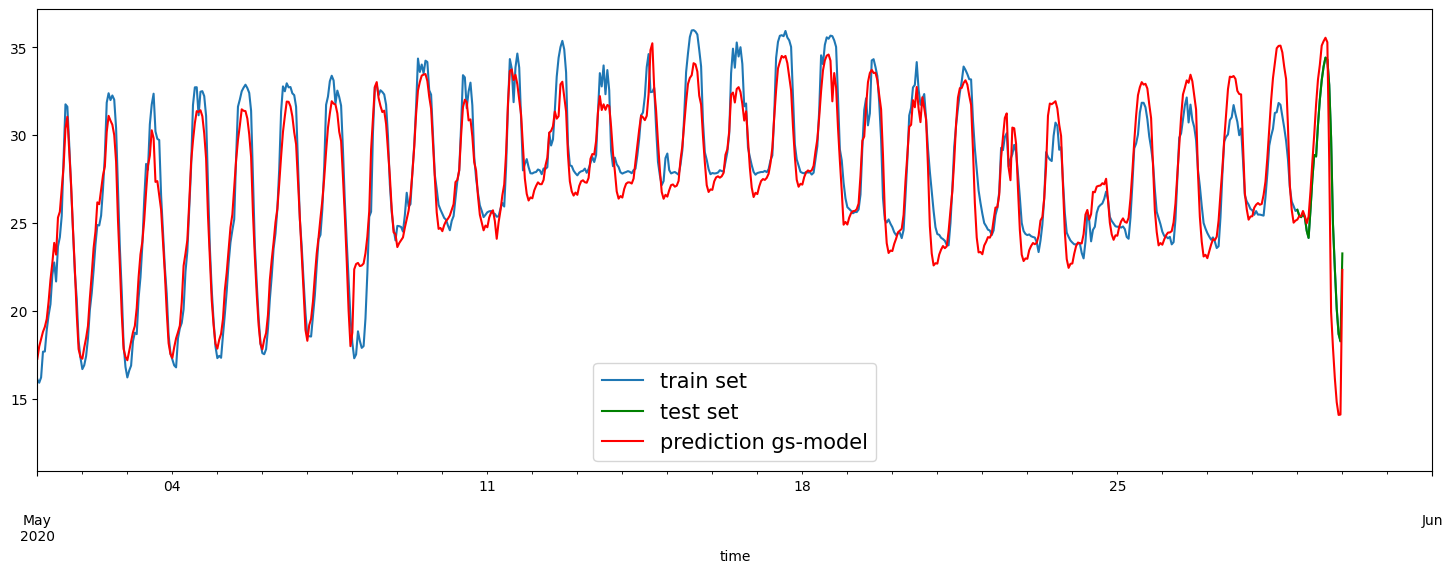

In [35]:
fig, ax = plt.subplots(figsize=(18,6))
train[['Tair']].plot(ax=ax)
test[['Tair']].plot(ax=ax, c='green')
all_data[['grid_pred']].loc['2020 May':].plot(ax=ax, c='red')
ax.legend(["train set", "test set", "prediction gs-model"], prop={'size': 15});
plt.xlim(pd.Timestamp('2020-05-01'), pd.Timestamp('2020-06-01'));

<a id='f'></a>
## Training model (Random Forest + GridSearchCV)

In this section we train a Random Forest model with GridSearchCV. 

In [24]:
rbf = RepeatingBasisFunction(n_periods=24,
                             remainder='passthrough',
                             column='hour_of_day')
model = Pipeline([
    ('preprocess', rbf),
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor())
])

parameters = {
    'model__max_depth':[1,2,3,4,5,7,8,9,10]
}

tscv = TimeSeriesSplit(n_splits=6)

for train_index, test_index in tscv.split(X_train):
    print(f"TRAIN: [{train_index.min(), train_index.max()}]", 
         f"TEST: [{test_index.min(), test_index.max()}]")

TRAIN: [(0, 569)] TEST: [(570, 1138)]
TRAIN: [(0, 1138)] TEST: [(1139, 1707)]
TRAIN: [(0, 1707)] TEST: [(1708, 2276)]
TRAIN: [(0, 2276)] TEST: [(2277, 2845)]
TRAIN: [(0, 2845)] TEST: [(2846, 3414)]
TRAIN: [(0, 3414)] TEST: [(3415, 3983)]


In [25]:
gsearch_rf = GridSearchCV(estimator=model, cv=tscv,
                        param_grid=parameters) 


gsearch_rf.fit(X_train, y_train)

all_data['grid_pred_rf'] = gsearch_rf.predict(all_data.drop(columns="Tair"))

/usr/local/lib/python3.10/site-packages/sklearn/pipeline.py:406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.10/site-packages/sklearn/pipeline.py:406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.10/site-packages/sklearn/pipeline.py:406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.10/site-packages/sklearn/pipeline.py:406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change th

/usr/local/lib/python3.10/site-packages/sklearn/pipeline.py:406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.10/site-packages/sklearn/pipeline.py:406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.10/site-packages/sklearn/pipeline.py:406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.10/site-packages/sklearn/pipeline.py:406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change th

In [37]:
train_pred = gsearch_rf.predict(X_train)
test_pred = gsearch_rf.predict(X_test)

In [38]:
# Calculate scores.
mae_train = mean_absolute_error(y_train, train_pred).round(3)
mse_train = mean_squared_error(y_train, train_pred).round(3)
rmse_train = np.sqrt(mean_squared_error(y_train, train_pred)).round(3)
mape_train = mean_absolute_percentage_error(y_train, train_pred).round(3)
r2_train = r2_score(y_train, train_pred).round(3)

mae_test = mean_absolute_error(y_test, test_pred).round(3)
mse_test = mean_squared_error(y_test, test_pred).round(3)
rmse_test = np.sqrt(mean_squared_error(y_test, test_pred)).round(3)
mape_test = mean_absolute_percentage_error(y_test, test_pred).round(3)
r2_test = r2_score(y_test, test_pred).round(3)



# Report. 
print(f'TRAIN | MAE: {mae_train}')
print(f'TRAIN | MSE: {mse_train}')
print(f'TRAIN | RMSE: {rmse_train}')
print(f'TRAIN | MAPE: {mape_train}')
print(f'TRAIN | r2: {r2_train}')
print(f'TEST | MAE: {mae_test}')
print(f'TEST | MSE: {mse_test}')
print(f'TEST | RMSE: {rmse_test}')
print(f'TEST | MAPE: {mape_test}')
print(f'TEST | r2: {r2_test}')

TRAIN | MAE: 0.43
TRAIN | MSE: 0.332
TRAIN | RMSE: 0.576
TRAIN | MAPE: 0.019
TRAIN | r2: 0.982
TEST | MAE: 0.446
TEST | MSE: 0.476
TEST | RMSE: 0.69
TEST | MAPE: 0.016
TEST | r2: 0.978


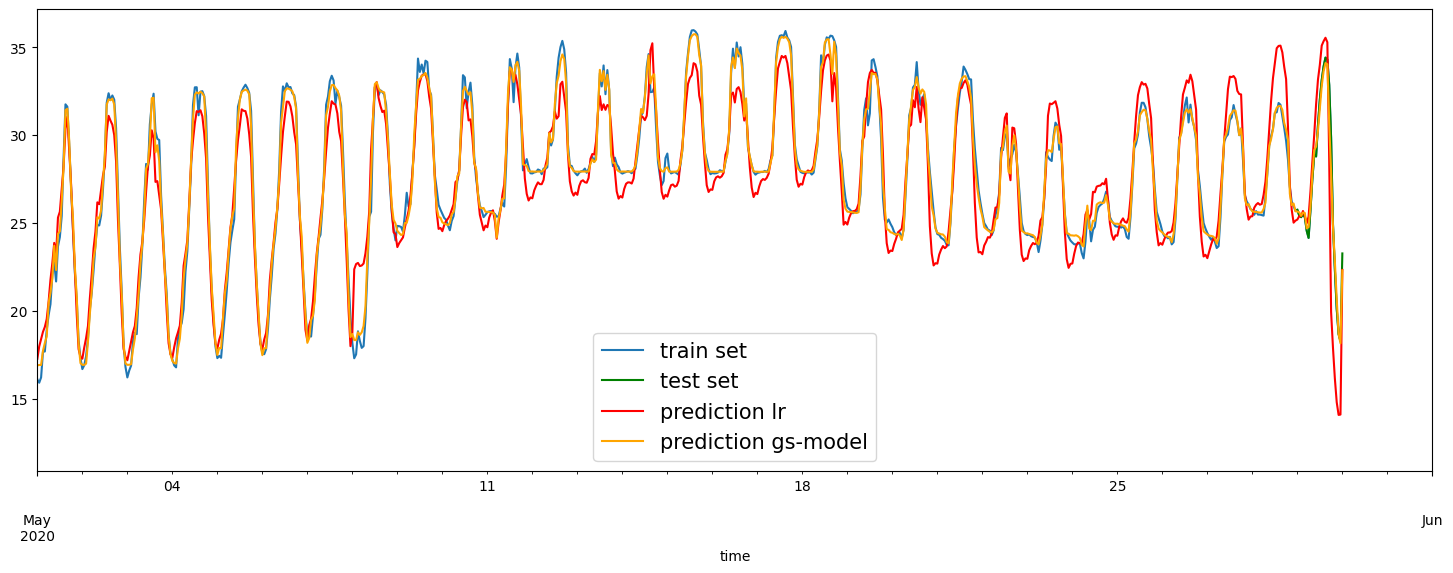

In [39]:
fig, ax = plt.subplots(figsize=(18,6))
train[['Tair']].plot(ax=ax)
test[['Tair']].plot(ax=ax, c='green')
all_data[['grid_pred']].loc['2020 May':].plot(ax=ax, c='red')
all_data[['grid_pred_rf']].loc['2010 May':].plot(ax=ax, c='orange')
ax.legend(["train set", "test set", "prediction lr", "prediction gs-model", "prediction gs-model rf"], prop={'size': 15});
plt.xlim(pd.Timestamp('2020-05-01'), pd.Timestamp('2020-06-01'));